In [532]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import exp, array, random, dot, tanh
from sklearn import datasets
import copy
np.random.seed(10)

from math import exp
from random import seed
# Test training backprop algorithm
seed(2)

## Some useful functions
    - A nonlinear function (sigmoid or tanh)
        - By default, I used tanh because sigmoid can cause an overflow problem.
        - One can also see the sigmoid function below in the comments in the code.
    - Activation function
    - Sum of squared error function
    - Plotting errors function
    - Shuffling two vectors together function
    - Creating a 'jumps' list which holds weights

In [533]:
'''
def sigmoid(x,deriv=False):
    if deriv==True:
        return sigmoid(x)*(1-sigmoid(x))
    #if np.amin(np.array(x)) < -710:
    #    print('Warning: There may be overflow in sigmoid.')
    return 1 / (1 + np.exp(-1*np.array(x)))
'''
def nonlin(x,deriv=False):
    if deriv==True:
        return 1-tanh(x)**2
    return tanh(x)

def activate(weights,prev_layer):
    return nonlin(np.dot(weights[:-1],prev_layer) + weights[-1])

def sum_of_squared_error(v1,v2):
    if(len(v1)!=len(v2)):
        print("Lengths of vectors must be consistent.")
        return -1
    return np.sum(np.square(np.array(v1)-np.array(v2)))

def plot_errors(ERRORS,labelx='Epoch',labely='Total Error',figsize=(10,3)):
    # PLot the error as a function of iteratation
    plt.figure(figsize=figsize)
    plt.plot(ERRORS)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.show()

def shuffle_together(x,y):
    together = list(zip(x, y))
    random.shuffle(together)
    x, y = zip(*together)
    return np.asarray(list(x)),  np.asarray(list(y))

def create_jump_list(sizes):
    jumps = list()
    for i in range(1,len(sizes)):
        jumps.append(Jump(sizes[i-1],sizes[i]))
    return jumps

# Jump object (Weights between layers)

In [534]:
class Jump():
    def __init__(self,left,right):
        #self.weights = random.random((left, right))
        self.weights = np.random.uniform(low=-1,high=1,size=(left,right))

# Network class with all functions in it
- Network is initiated with given weights in jumps array.
- Forward propagation is returns values on the output layer when given an input row.
- Train function trains the network with given:
    - Training set
    - Number of epochs
    - Learning rate
    - Error threshold
- The comments in the code can be read to understand the working basics of the backpropagation.

In [618]:
class Network():
    # Network is initiated with given weights in jumps array.
    def __init__(self,jumps):
        self.jumps = jumps
        self.n_jumps = len(jumps)
    
    # Training function, returns errors in each epoch.
    def train(self,X_train,y_train,n_epoch,l_rate,threshold):
        SSE_output = []
        for epoch in range(n_epoch):
            
            cur_outputs = []
            left = X_train[:]
            
            for jump in self.jumps:
                left = nonlin(dot(left,jump.weights))
                cur_outputs.append(left)
            
            errors = [0]*self.n_jumps
            deltas = [0]*self.n_jumps
            
            # Error and delta at output layer
            errors[-1] = y_train - cur_outputs[-1]
            deltas[-1] = errors[-1]*nonlin(cur_outputs[-1],deriv=True)
            
            # Append the sum of squared error to SSE_output
            SSE_output.append(np.sum(np.square(errors[-1])))
            if SSE_output[-1]<threshold:
                break
            
            # Calculating the errors and deltas for backpropagation
            for i in reversed(range(self.n_jumps-1)):
                errors[i] = deltas[i+1].dot(self.jumps[i+1].weights.T)
                deltas[i] = errors[i]*nonlin(cur_outputs[i],deriv=True)
            
            # Adjusting changes
            adjustments = []
            adjustments.append(X_train.T.dot(deltas[0]))
            for i in range(1,len(self.jumps)):
                adjustments.append(cur_outputs[i-1].T.dot(deltas[i]))
            
            # The backpropagation: changing weights
            for i,jump in enumerate(self.jumps):
                jump.weights+=l_rate*adjustments[i]
        return SSE_output
    
    # Gives a result on the output layer when given an input row.
    def forward_propagate(self,row):
        left = row
        for jump in self.jumps:
            left = nonlin(dot(left,jump.weights))
        return left

# Q1 XOR Problem

### Network creation for XOR Problem
- It has a 3 layer structure which can be changed.

In [614]:
sizes_xor = [2,8,1]
X_train_xor = np.asarray([[0,0],[0,1],[1,0],[1,1]])
y_train_xor = [[0],[1],[1],[0]]

X_test_xor = [[0,0],[0,1],[1,0],[1,1]]
y_test_xor = [[0],[1],[1],[0]]

jumps_xor = create_jump_list(sizes_xor)
network_xor = Network(jumps_xor)

### Training the XOR network

In [615]:
n_epoch_xor   = 10000
l_rate_xor    = 0.005
threshold_xor = 0.003

SSE_errors_xor = network_xor.train(X_train_xor,y_train_xor,n_epoch_xor,l_rate_xor,threshold_xor)
test_results_xor = network_xor.forward_propagate(X_test_xor)

### Plotting errors vs Epochs for XOR

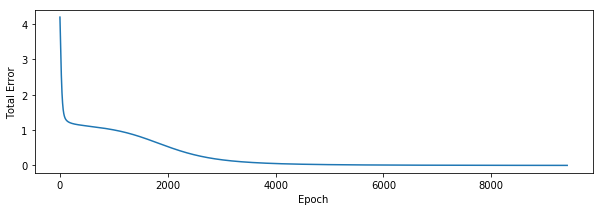

In [616]:
plot_errors(SSE_errors_xor)

### Accuracy for XOR

In [617]:
print('\t  Calculated VS Intended')
acc = 0
for i,elm in enumerate(test_results_xor):
    prediction = elm[0]>0.5
    print(elm[0],'==>',int(prediction),'vs',y_test_xor[i][0])
    if prediction == y_test_xor[i]:
        acc+=1
        
print('Accuracy:',acc/len(y_test_xor))

	  Calculated VS Intended
0.0 ==> 0 vs 0
0.963383338401 ==> 1 vs 1
0.963228616815 ==> 1 vs 1
0.0175018412371 ==> 0 vs 0
Accuracy: 1.0


# Q2 Sin

## Q2.1 Sin for 3 layers (it usually works worse than 4 layers )

In [606]:
sizes_sin = [1,10,1]

X_train_sin = np.random.uniform(low=0, high=2*np.pi, size=(40,1))
X_test_sin = np.random.uniform(low=0, high=2*np.pi, size=(20,1))

y_train_sin = np.sin(X_train_sin)
y_test_sin = np.sin(X_test_sin)

In [607]:
jumps_sin = create_jump_list(sizes_sin)
network_sin = Network(jumps_sin)

In [608]:
n_epoch_sin   = 100000
l_rate_sin    = 0.0001
threshold_sin = 2

SSE_errors_sin = network_sin.train(X_train_sin,y_train_sin,n_epoch_sin,l_rate_sin,threshold_sin)
test_results_sin = network_sin.forward_propagate(X_test_sin)

### Please note that:
In the plot below, even though the maximum number of epochs is 100.000, this training is done after 17.500 epochs since the errors is below given threshold.

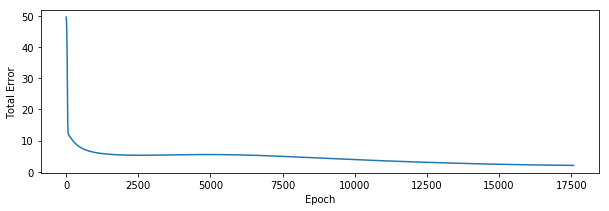

In [609]:
plot_errors(SSE_errors_sin)

In [610]:
print('Calculated VS Intended')
for i,elm in enumerate(test_results_sin):
    print('%.3f\t vs   %.3f' % (elm[0],y_test_sin[i][0]))

Calculated VS Intended
-0.614	 vs   -0.983
-0.801	 vs   -0.704
0.773	 vs   0.876
-0.596	 vs   -0.971
-0.839	 vs   -0.380
0.555	 vs   0.693
0.787	 vs   0.952
0.292	 vs   0.290
-0.761	 vs   -0.880
0.166	 vs   0.102
0.357	 vs   0.388
0.048	 vs   -0.072
0.501	 vs   0.609
-0.080	 vs   -0.262
0.761	 vs   0.994
0.769	 vs   0.999
0.772	 vs   0.873
0.323	 vs   0.336
-0.725	 vs   -0.960
0.533	 vs   0.659


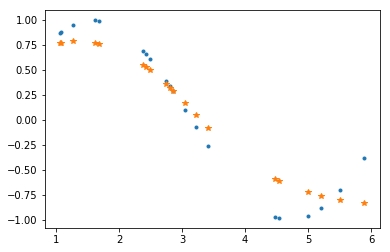

In [611]:
plt.figure()
plt.plot(X_test_sin, y_test_sin,'.')
plt.plot(X_test_sin,test_results_sin,'*')
plt.show()

# Q2.2 Sin for 4 layers 

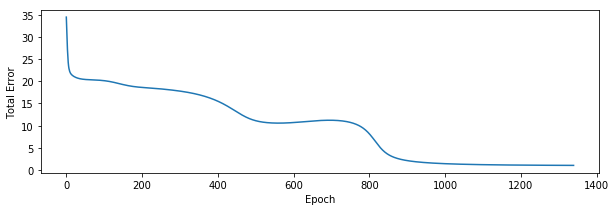

In [619]:
sizes_sin = [1,10,7,1]

X_train_sin = np.random.uniform(low=0, high=2*np.pi, size=(40,1))
X_test_sin = np.random.uniform(low=0, high=2*np.pi, size=(20,1))

y_train_sin = np.sin(X_train_sin)
y_test_sin = np.sin(X_test_sin)

jumps_sin = create_jump_list(sizes_sin)
network_sin = Network(jumps_sin)

n_epoch_sin   = 20000
l_rate_sin    = 0.0005
threshold_sin = 1

SSE_errors_sin = network_sin.train(X_train_sin,y_train_sin,n_epoch_sin,l_rate_sin,threshold_sin)
test_results_sin = network_sin.forward_propagate(X_test_sin)

plot_errors(SSE_errors_sin)

In [620]:
print('    Calculated VS Intended')
acc = 0
for i,elm in enumerate(test_results_sin):
    print('%.3f\t vs   %.3f' % (elm[0],y_test_sin[i][0]))

    Calculated VS Intended
0.835	 vs   0.973
0.640	 vs   0.489
0.821	 vs   0.867
-0.850	 vs   -1.000
-0.900	 vs   -0.927
0.242	 vs   0.230
-0.951	 vs   -0.381
0.474	 vs   0.502
-0.954	 vs   -0.324
-0.833	 vs   -0.997
-0.963	 vs   -0.012
0.772	 vs   0.711
-0.620	 vs   -0.747
0.730	 vs   0.870
-0.960	 vs   -0.111
-0.619	 vs   -0.745
0.827	 vs   0.892
0.831	 vs   0.995
0.823	 vs   1.000
0.210	 vs   0.195


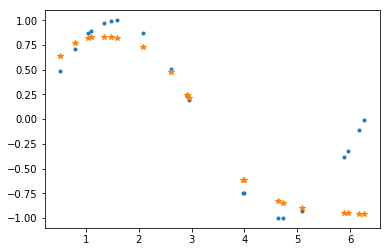

In [621]:
plt.figure()
plt.plot(X_test_sin, y_test_sin,'.')
plt.plot(X_test_sin,test_results_sin,'*')
plt.show()

# Question 3 ( 3 and 4 layer networks for Iris)

### Load, shuffle and split the Iris dataset

In [586]:
iris = datasets.load_iris()
X_init, y_init = iris.data, iris.target
X, y = shuffle_together(X_init,y_init)

X_train, X_test = X[:125],X[125:]
y_train, y_test = y[:125],y[125:]

# To be consistent in the ANN model, change y_train and y_test into
# 0 => [1 0 0]
# 1 => [0 1 0]
# 2 => [0 0 1]
def iris_y_into_3_nodes(y):
    temp = []
    for i in range(len(y)):
        if y[i] == 0:
            temp.append([1,0,0])
        elif y[i] == 1:
            temp.append([0,1,0])
        else:
            temp.append([0,0,1])
    return np.array(temp)

y_train = iris_y_into_3_nodes(y_train)
y_test  = iris_y_into_3_nodes(y_test)

### Network creation for Iris Dataset (3 Layers)

In [587]:
sizes_iris = [4,10,3]
jumps_iris = create_jump_list(sizes_iris)

network_iris = Network(jumps_iris)

### Training the network for Iris

In [588]:
n_epoch_iris   = 10000
l_rate_iris    = 0.001
threshold_iris = 6

SSE_errors_iris =network_iris.train(X_train,y_train,n_epoch_iris,l_rate_iris,threshold_iris)
test_results_iris = network_iris.forward_propagate(X_test)

### Accuracy for Iris

In [589]:
print(' [0]\t  [1]\t  [2]\t    Calculated VS Intended')
acc = 0
for i,elm in enumerate(test_results_iris):
    for o in elm:
        print('%.3f\t' % o, end =" ")
    print('\t==> ', np.where(elm == max(elm))[0][0],'vs', int(np.where(y_test[i]==1)[0]))
    
    if np.where(elm == max(elm))[0][0] == np.where(y_test[i] == 1)[0][0]:
        acc += 1
print('Accuracy:',acc/len(y_test))

 [0]	  [1]	  [2]	    Calculated VS Intended
-0.004	 0.973	 -0.089	 	==>  1 vs 1
-0.001	 0.983	 0.041	 	==>  1 vs 1
0.999	 -0.090	 0.005	 	==>  0 vs 0
-0.004	 0.918	 0.255	 	==>  1 vs 1
0.039	 0.025	 0.949	 	==>  2 vs 2
0.025	 -0.019	 0.945	 	==>  2 vs 2
0.004	 0.980	 -0.008	 	==>  1 vs 1
0.999	 -0.031	 -0.006	 	==>  0 vs 0
0.998	 -0.001	 0.014	 	==>  0 vs 0
-0.041	 0.059	 0.960	 	==>  2 vs 2
0.009	 0.943	 0.018	 	==>  1 vs 1
0.998	 -0.009	 0.008	 	==>  0 vs 0
-0.074	 -0.077	 0.954	 	==>  2 vs 2
0.023	 0.489	 0.833	 	==>  2 vs 1
-0.004	 0.959	 -0.039	 	==>  1 vs 1
0.031	 0.007	 0.932	 	==>  2 vs 2
0.998	 0.111	 -0.025	 	==>  0 vs 0
0.999	 -0.056	 -0.000	 	==>  0 vs 0
0.002	 -0.024	 0.951	 	==>  2 vs 2
0.052	 0.719	 0.527	 	==>  1 vs 2
-0.012	 0.014	 0.948	 	==>  2 vs 2
0.999	 -0.114	 0.009	 	==>  0 vs 0
0.999	 0.004	 0.002	 	==>  0 vs 0
0.031	 0.543	 0.764	 	==>  2 vs 2
0.007	 0.945	 -0.029	 	==>  1 vs 1
Accuracy: 0.92


### Plotting errors vs Epochs for Iris

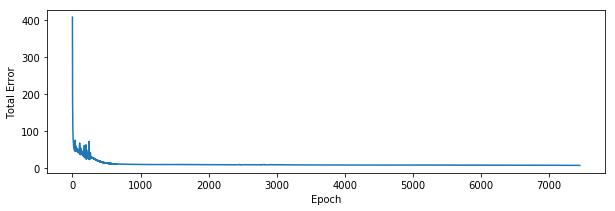

In [590]:
plot_errors(SSE_errors_iris)

# Q3.2 XOR with 4 layers

### Network creation for Iris Dataset (4 Layers)
### Training the network for Iris
### Accuracy for Iris
### Plotting errors vs Epochs for Iris

 [0]	  [1]	  [2]	    Calculated VS Intended
0.041	 0.033	 0.945	 	==>  2 vs 2
0.995	 -0.058	 -0.008	 	==>  0 vs 0
0.375	 0.997	 0.032	 	==>  1 vs 1
0.700	 0.990	 0.073	 	==>  1 vs 1
0.037	 -0.018	 0.966	 	==>  2 vs 2
0.012	 -0.028	 0.979	 	==>  2 vs 2
0.022	 0.999	 0.009	 	==>  1 vs 1
-0.018	 0.999	 0.026	 	==>  1 vs 1
0.994	 0.056	 0.057	 	==>  0 vs 0
0.029	 -0.027	 0.972	 	==>  2 vs 2
0.995	 -0.055	 -0.004	 	==>  0 vs 0
0.135	 0.998	 0.006	 	==>  1 vs 1
0.994	 -0.022	 -0.004	 	==>  0 vs 0
0.994	 0.007	 -0.012	 	==>  0 vs 0
0.995	 -0.047	 0.008	 	==>  0 vs 0
0.995	 -0.021	 0.016	 	==>  0 vs 0
0.994	 -0.022	 -0.004	 	==>  0 vs 0
0.020	 -0.026	 0.971	 	==>  2 vs 2
0.022	 0.130	 0.865	 	==>  2 vs 2
0.073	 0.998	 -0.000	 	==>  1 vs 1
-0.010	 -0.050	 0.984	 	==>  2 vs 2
0.081	 0.985	 -0.107	 	==>  1 vs 1
0.064	 0.996	 -0.025	 	==>  1 vs 1
0.994	 -0.013	 -0.013	 	==>  0 vs 0
0.995	 -0.053	 0.000	 	==>  0 vs 0
Accuracy: 1.0


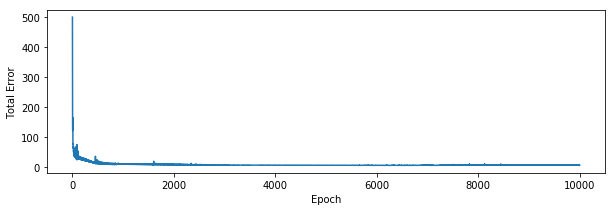

In [593]:
iris = datasets.load_iris()
X_init, y_init = iris.data, iris.target
X, y = shuffle_together(X_init,y_init)

X_train, X_test = X[:125],X[125:]
y_train, y_test = y[:125],y[125:]

y_train = iris_y_into_3_nodes(y_train)
y_test  = iris_y_into_3_nodes(y_test)

sizes_iris = [4,10,10,3]
jumps_iris = create_jump_list(sizes_iris)

network_iris = Network(jumps_iris)

n_epoch_iris   = 10000
l_rate_iris    = 0.001
threshold_iris = 4

SSE_errors_iris =network_iris.train(X_train,y_train,n_epoch_iris,l_rate_iris,threshold_iris)
test_results_iris = network_iris.forward_propagate(X_test)

print(' [0]\t  [1]\t  [2]\t    Calculated VS Intended')
acc = 0
for i,elm in enumerate(test_results_iris):
    for o in elm:
        print('%.3f\t' % o, end =" ")
    print('\t==> ', np.where(elm == max(elm))[0][0],'vs', int(np.where(y_test[i]==1)[0]))
    
    if np.where(elm == max(elm))[0][0] == np.where(y_test[i] == 1)[0][0]:
        acc += 1
print('Accuracy:',acc/len(y_test))

plot_errors(SSE_errors_iris)

# Discussion & Conclusion
- I have written an MLP network class which can be created with arbitrary number of layers and nodes in each layer. I have solved these problems: 
    - XOR problem (3 layers)
    - Sin problem (both 3 and 4 layers)
    - Iris problem (both 3 and 4 layers)
- Note that in the implementation, a network stops training after error is below given error threshold OR given max epochs is exceeded.
- The analysis of the model can be done with different hyperparameters such as "learning rate" and different number of layers and nodes.
- We can see that our model usually works well. But sometimes it behaves unexpectedly because of the bad choice of hyperparameters. This might be considered as a drawback of the algorithm. This is a common problem in the ANN models and it is usually solved empirically.
- I made use of this links during the implementation: 
    - https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/
    - https://medium.com/technology-invention-and-more/how-to-build-a-multi-layered-neural-network-in-python-53ec3d1d326a